# Predicción de Series Temporales con ARIMA

Las series temporales ofrecen la oportunidad de pronosticar valores futuros. Basándose en los valores anteriores, las series temporales pueden utilizarse para pronosticar tendencias en economía, clima y planificación de la capacidad, por nombrar algunos. Es importante tener en cuenta que, dadas las propiedades específicas de los datos de series temporales, se requieren métodos estadísticos especializados.

Nuestro objetivo es producir estimaciones (pronósticos) fiables de series temporales. Comenzaremos introduciendo los conceptos de *autocorrelación*, *estacionalidad* y *temporalidad*, y aplicaremos uno de los métodos más comúnmente utilizados para el tratamiento de series temporales, conocido como **ARIMA**.

Uno de los métodos disponibles para modelar y predecir puntos futuros de una serie de tiempo se conoce como **SARIMAX**: **Seasonal AutoRegressive Integrated Moving Averages with eXogenous regressors**. 

Nos centraremos principalmente en **ARIMA**, que se utiliza para ajustar (fit) los datos de series temporales para una mejor comprensión y predecir los puntos futuros de las series temporales.

https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

----------

## Paso 1 — Importamos libererias

In [30]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')  # voy a usar el estilo de pyploy 538

## Paso 2 — Cargamos el dataset

Vamos a trabajar con un dataset llamado *"Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A."* con muestras de CO2 desde Marzo de 1958 a Diciembre  de 2001. 

In [31]:
data = sm.datasets.co2.load_pandas()

In [32]:
y=data.data

In [33]:
type(y)

pandas.core.frame.DataFrame

In [34]:
y.shape

(2284, 1)

In [35]:
y.index

Index(['19580329', '19580405', '19580412', '19580419', '19580426', '19580503',
       '19580510', '19580517', '19580524', '19580531',
       ...
       '20011027', '20011103', '20011110', '20011117', '20011124', '20011201',
       '20011208', '20011215', '20011222', '20011229'],
      dtype='object', length=2284)

In [36]:
# Paso a datetime el indice
y.index = pd.to_datetime(y.index)

Vamos a preprocesar nuestros datos un poco. Los datos semanales pueden ser difíciles de trabajar, ya que es una cantidad de tiempo corta para este dataset, así que vamos a usar promedios mensuales en su lugar. Haremos la conversión con la función de ```resample```. Para simplificar, también podemos usar la función ```fillna()``` para asegurarnos de que no nos falten valores en nuestras series temporales.


In [37]:
# El string 'MS' agrupa los datos en buckets 
y = y['co2'].resample('MS').mean()

# La función bfill implica que usaremos los valores previos para completar los valores que faltan
y = y.fillna(y.bfill())

print(y)

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
1958-08-01    314.950000
1958-09-01    313.500000
1958-10-01    313.425000
1958-11-01    313.425000
1958-12-01    314.700000
1959-01-01    315.500000
1959-02-01    316.700000
1959-03-01    316.733333
1959-04-01    317.675000
1959-05-01    318.325000
1959-06-01    318.025000
1959-07-01    316.525000
1959-08-01    314.900000
1959-09-01    313.825000
1959-10-01    313.400000
1959-11-01    314.875000
1959-12-01    315.525000
1960-01-01    316.380000
1960-02-01    316.975000
1960-03-01    317.575000
1960-04-01    319.120000
1960-05-01    319.925000
1960-06-01    319.450000
1960-07-01    318.060000
1960-08-01    315.775000
                 ...    
1999-07-01    369.000000
1999-08-01    366.700000
1999-09-01    364.675000
1999-10-01    365.140000
1999-11-01    366.650000
1999-12-01    367.900000
2000-01-01    369.020000
2000-02-01    369.375000
2000-03-01    370.400000


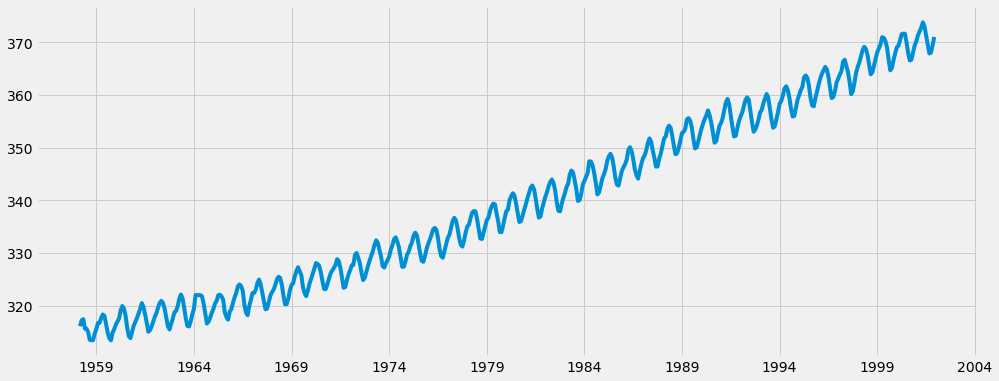

In [39]:
# pintamos los datos para ver que aspecto tienen
y.plot(figsize=(15, 6))
plt.show()

Ya se distinguen algunos patrones al graficar los datos. La serie temporal tiene un patrón estacional evidente, así como una tendencia general creciente.

Revisar la "A Guide to Time Series Visualization with Python 3" https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-visualization-with-python-3 para una explicación mas detallada.

## Step 3 — El modelo ARIMA

Uno de los métodos más comunes utilizados en el pronóstico de series de tiempo se conoce como el modelo **ARIMA** (AutoregRessive Integrated Moving Average) o Media Móvil Integrada Autorregresiva. 

ARIMA es un modelo que se puede adaptar a los datos de series temporales para describir mejor o predecir los puntos futuros de la serie.

Hay 3 enteros (p, d, q) que se usan para parametrizar los modelos ARIMA. 

Por esto, los modelos ARIMA se denotan como **ARIMA(p, d, q)**. Estos 3 parámetros representan la "seasonality", la tendencia y el ruido en el dataset:

- **p** es la parte auto-regresiva del modelo. Nos permite incorporar el efecto de los valores del pasado en nuestro modelo. Intuitivamente, esto sería similar a decir que es probable que mañana haga calor si ha estado caluroso los últimos 3 días.

- **d** es la parte integrada del modelo. Esto incluye términos en el modelo que incorporan la cantidad de diferenciación (es decir, el número de puntos de tiempo pasados a restar del valor actual) a aplicar a la serie temporal. Intuitivamente, esto sería similar a afirmar que es probable que mañana haya la misma temperatura si la diferencia de temperatura en los últimos tres días ha sido muy pequeña.

- **q** es la parte de la media movil del modelo. Esto nos permite establecer el error de nuestro modelo como una combinación lineal de los valores de error observados en puntos de tiempo anteriores en el pasado.

En el caso de los efectos estacionales (seasonal), utilizamos el **ARIMA estacional**, que se denomina ** SARIMAX - ARIMA(p,d,q)(P,D,Q)s**. Aquí, (p, d, q) son los parámetros *no estacionales* descritos anteriormente, mientras que (P, D, Q) siguen la misma definición pero se aplican al *componente estacional* de la serie temporal. El término **s** es la periodicidad de las series temporales (4 para los períodos trimestrales, 12 para los períodos anuales, etc.).


## Step 4 — Selección de parámetros para un modelo de Series Temporales ARIMA

Cuando buscamos ajustar los datos de series temporales con un modelo ARIMA estacional, nuestro primer objetivo es encontrar los valores **(p,d,q)(P,D,Q)s** que optimizan una métrica de interés. 

Existen muchas directrices y mejores prácticas para lograr este objetivo, sin embargo, la correcta parametrización de los modelos ARIMA puede ser un proceso artesanal que requiere experiencia y tiempo. Algunos lenguajes de programación como R proporcionan formas automatizadas de resolver este problema.  

Vamos a desarrollar un código Python para seleccionar los valores óptimos de los parámetros para nuestro modelo ARIMA(p,d,q)(P,D,Q).

Usaremos una "grid search" para explorar iterativamente diferentes combinaciones de parámetros. Para cada combinación de parámetros, entrenamos un nuevo modelo con la función SARIMAX() del módulo **statsmodels** y evaluamos su calidad. Una vez que hayamos explorado todo el espacio de parámetros, nuestro conjunto óptimo de parámetros será el que produzca el mejor resultado para nuestra métrica. 

In [40]:
# definimos que los parametros p, d y q tomen valores entre 0 y 2

p = d = q = range(0, 2)

# Generamos las diferentes combinaciones de p, q y q 
pdq = list(itertools.product(p, d, q))

# Genera todas las diferentes combinaciones 'seasonales' de ternas p, q y q 
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Ejemplos de combinaciones de parametros para SARIMAX...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Ejemplos de combinaciones de parametros para SARIMAX...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


Ahora podemos utilizar las ternas de parámetros definidos anteriormente para automatizar el proceso de training y evaluar los modelos ARIMA en diferentes combinaciones. En ML, este proceso se conoce como "grid search" (u optimización de hiperparámetros).

Cuando se evalúan y comparan modelos estadísticos "ajustados" con diferentes parámetros, cada uno de estos modelos se puede clasificar en función de su precisión o de su capacidad para predecir los puntos de datos futuros. Utilizaremos el valor **AIC (Akaike Information Criterion)**, que se puede recuperar facilmente si entrenamos los modelos ARIMA mediante **statsmodel**. 

A un modelo que se ajuste muy bien a los datos y que utilice muchas funciones se le asignará una puntuación AIC mayor que a un modelo que utilice menos funciones para lograr la misma calidad de ajuste. Por lo tanto, estamos interesados en encontrar el modelo que produzca **el valor AIC más bajo**.

El siguiente código itera a través de las combinaciones de parámetros y utiliza la función SARIMAX de **statsmodels** para entrenar al modelo ARIMA estacional correspondiente. 

Aquí, el argumento **order** especifica los parámetros **(p, d, q)**, mientras que el argumento **seasonal_order** especifica el componente estacional (P, D, Q, S) del modelo *Seasonal ARIMA*. 

Después de entrenar cada modelo de SARIMAX(), se muestra su respectiva puntuación AIC.


In [41]:
warnings.filterwarnings("ignore") # ignoramos los "warning messages"

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:7612.583429881011
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6787.343624036737
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1854.828234141261
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1596.7111727641156
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1058.9388921320026
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1056.2878350086824
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1361.6578978072075
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1044.7647913337166
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6881.04875494035
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6072.662327416359
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1379.1941066979707
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1241.417471676608
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1095.3311709016261
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:877.8954598127478
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1119.5957893619993
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:807.0912988525697
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1675.8086923024293
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1240.2211199194094
A

La salida de los AIC sugiere que SARIMAX(1, 1, 1)x(1, 1, 1, 12) obtiene el AIC mas bajo (277.78). Por lo tanto, debemos considerar que esta es una opción óptima entre todos los modelos que hemos evaluado.

## Step 5 — Entrenando el modelo SARIMAX

Utilizando una "grid search", hemos identificado el conjunto de parámetros que produce el mejor ajuste a nuestro dataset de series temporales. 

Incorporamos los valores óptimos de los parámetros en el modelo SARIMAX:

In [42]:
model = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = model.fit()

In [43]:
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3179      0.092      3.443      0.001       0.137       0.499
ma.L1         -0.6255      0.076     -8.177      0.000      -0.775      -0.476
ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
ma.S.L12      -0.8766      0.026    -33.754      0.000      -0.927      -0.826
sigma2         0.0971      0.004     22.638      0.000       0.089       0.106


La función ```summary()``` del modelo entrenado de SARIMAX devuelve bastante información. Nos centramos en la tabla de coeficientes:

- La columna ```coef``` muestra el peso (es decir, la importancia) de cada característica y cómo afecta cada una a las series temporales. 
- La columna ```P>|z|``` nos indica el nivel de significación de cada peso (```coef```). 
- Aquí, cada peso tiene un ```p valor``` inferior o cercano a ```0.05```, por lo que es razonable mantenerlos todos en nuestro modelo.

Al entrenar modelos ARIMA estacionales (y cualquier otro modelo), es importante ejecutar una evaluación del resultado  para asegurar que ninguna de las suposiciones hechas por el modelo han sido violadas. La función ```plot_diagnostics``` nos permite evaluar algunas características del modelo e investigar cualquier comportamiento inusual.


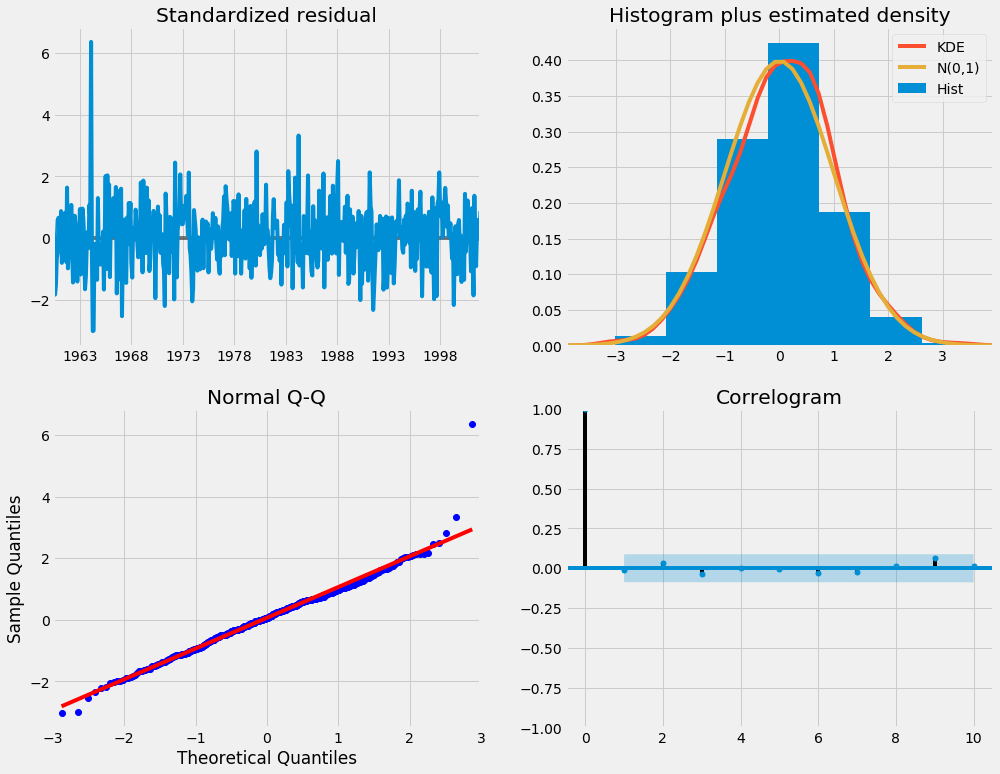

In [44]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Debemos asegurar que los **residuals** de nuestro modelo no estén correlacionados y que se distribuyen segun una distribución Normal con una media 0. Si el modelo ARIMA estacional no satisface estas propiedades, deberíamos revisar los hiperparámetros o el dataset.

En este caso, segun los **"plot_diagnostics"** del modelo, se ve que los residuos se distribuyen en base a lo siguiente:

- En el gráfico superior derecho, vemos que la línea roja ```KDE``` sigue de cerca a la curva Gaussiana ```N(0,1)```. Esto es una buena indicación de que los residuos se distribuyen normalmente.

- El ```qq-plot``` de abajo a la izquierda, muestra que la distribución de residuos (puntos azules) sigue una tendencia lineal de las muestras tomadas de una distribución ```N(0,1)```. De nuevo, esta es una indicación fuerte de que los residuos se distribuyen Normalmente. 

- La evolución de los residuos en el tiempo (arriba a la izquierda) no muestran una *"seasonality"* obvia y parecen mas bien "ruido blanco". Esto se confirma a través del grafico de autocorrelación (correlogram), que muestra que la serie temporal de los residuos tiene baja correlación con las versiones retrasadas de sí mismos.  


Estas observaciones nos llevan a la conclusión de que nuestro modelo produce un ajuste satisfactorio que puede ayudarnos a entender los datos de nuestras series temporales y a predecir valores futuros.

Aunque el ajuste es bueno, algunos parámetros de nuestro modelo ARIMA estacional podrían modificarse para mejorar aun más el ajuste de nuestro modelo. Por ejemplo, nuestra "grid search" sólo consideró un conjunto restringido de combinaciones de parámetros, por lo que podemos encontrar mejores modelos si ampliamos la búsqueda en la cuadrícula.


## Paso 6 — Validando las predicciones

Hemos obtenido un modelo para nuestra serie temporal que ahora puede utilizarse para elaborar predicciones. Vamos a comparar los valores pronosticados con los valores reales de las series temporales. 

Los atributos ```get_prediction()``` y ```conf_int()``` nos permiten obtener los valores y los intervalos de confianza asociados a las predicciones de las series temporales.

In [46]:
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), 
                              end=pd.to_datetime('2002-01-01'), 
                              dynamic=False)
pred_ci = pred.conf_int()

El código anterior fija la fecha de inicio en "Enero de 1998".

El argumento ```dynamic=False``` asegura que generamos predicciones usando el historial **completo** hasta ese punto.

Podemos graficar los valores reales y las predicciones de las series temporales de CO2 para ver qué tan bien lo hace el modelo. 

Al final de la serie hacemos un zoom cortando el índice de fecha.


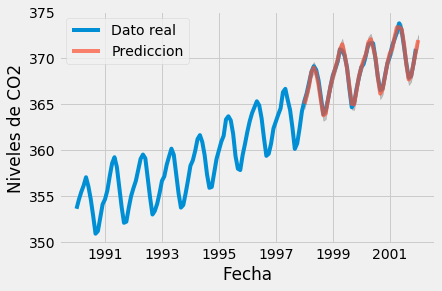

In [47]:
ax = y['1990':].plot(label='Dato real')
pred.predicted_mean.plot(ax=ax, label='Prediccion', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Fecha')
ax.set_ylabel('Niveles de CO2')
plt.legend()

plt.show()

En general, parece que nuestras previsiones se alinean muy bien con los valores reales, mostrando una tendencia al alza.

Para evaluar la exactitud del modelo utilizaremos el MSE (Mean Squared Error) como métrica. 

In [48]:
y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':]

# MSE
mse = ((y_forecasted - y_truth) ** 2).mean()
print('El Error Cuadratico Medio de la predicción es {}'.format(round(mse, 3)))

El Error Cuadratico Medio de la predicción es 0.073


El MSE de las predicciones es ```0.07```, que es bastante bajo. Un MSE de 0 indicaría que el modelo está prediciendo observaciones con una precisión perfecta, lo cual sería un escenario poco realista.

Sin embargo, una mejor representación de nuestro verdadero poder predictivo puede obtenerse usando predicciones dinámicas. En este caso, sólo utilizamos la información de la serie temporal hasta un cierto punto, y después de eso, las previsiones se generan utilizando valores de puntos temporales pronosticados anteriormente.

En el siguiente fragmento de código, vamos a calcular predicciones dinámicas a partir de **"Enero de 1998"** en adelante.


In [49]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1998-01-01'), 
                                      end=pd.to_datetime('2002-01-01'),
                                      dynamic=True, 
                                      full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

Al plotear los valores reales y estimados con el modelo dinámico, vemos que las predicciones son exactas. Todos los valores predichos (línea roja) coinciden bastante con los valores reales (línea azul), y están dentro de los intervalos de confianza.

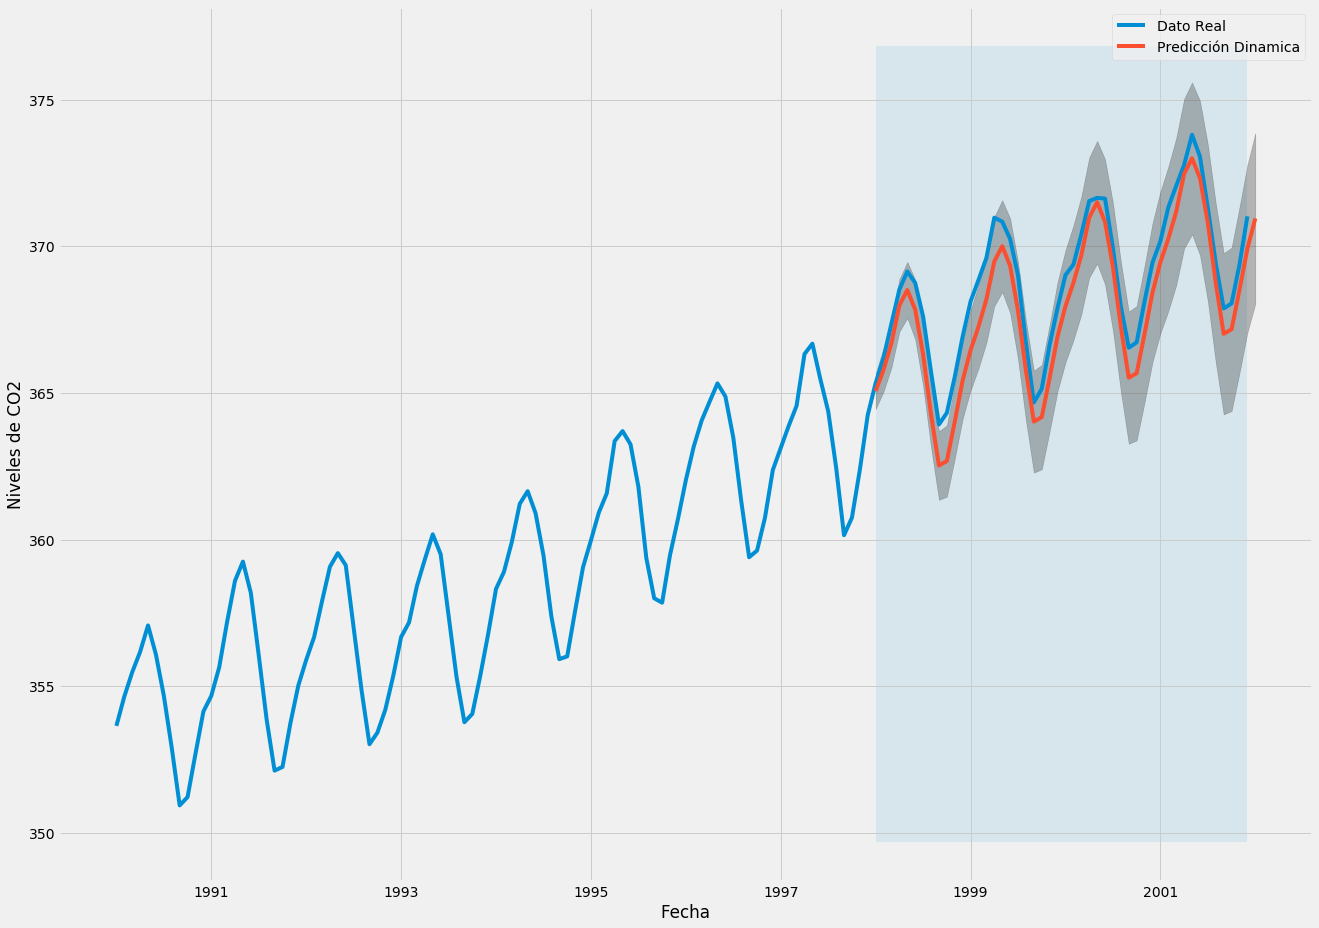

In [50]:
ax = y['1990':].plot(label='Dato Real', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Predicción Dinamica', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Fecha')
ax.set_ylabel('Niveles de CO2')

plt.legend()
plt.show()

Calculamos el MSE:

In [51]:
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['1998-01-01':]

mse = ((y_forecasted - y_truth) ** 2).mean()
print('El Error Cuadratico Medio de la predicción es {}'.format(round(mse, 2)))

El Error Cuadratico Medio de la predicción es 1.01


Las predicciones dinámicas arrojan un MSE de ```1.01```, algo mayor que la anterior dado que no estamos usando todos los datos anteriores para predecir el siguiente.

Tanto las previsiones "de un paso" como las "dinámicas" confirman que este modelo es válido. 


## Paso 7 — Generando predicciones

Como paso final, vemos cómo aprovechar nuestro modelo SARIMAX para pronosticar valores futuros. La función ```get_forecast()``` de nuestro modelo puede calcular predicciones para un número específico de pasos posteriores.

In [52]:
# Prediccion de 500 pasos adelante
pred_uc = results.get_forecast(steps=500)

# Calculamos el intervalo de confianza de la predicción
pred_ci = pred_uc.conf_int()

Ploteamos:

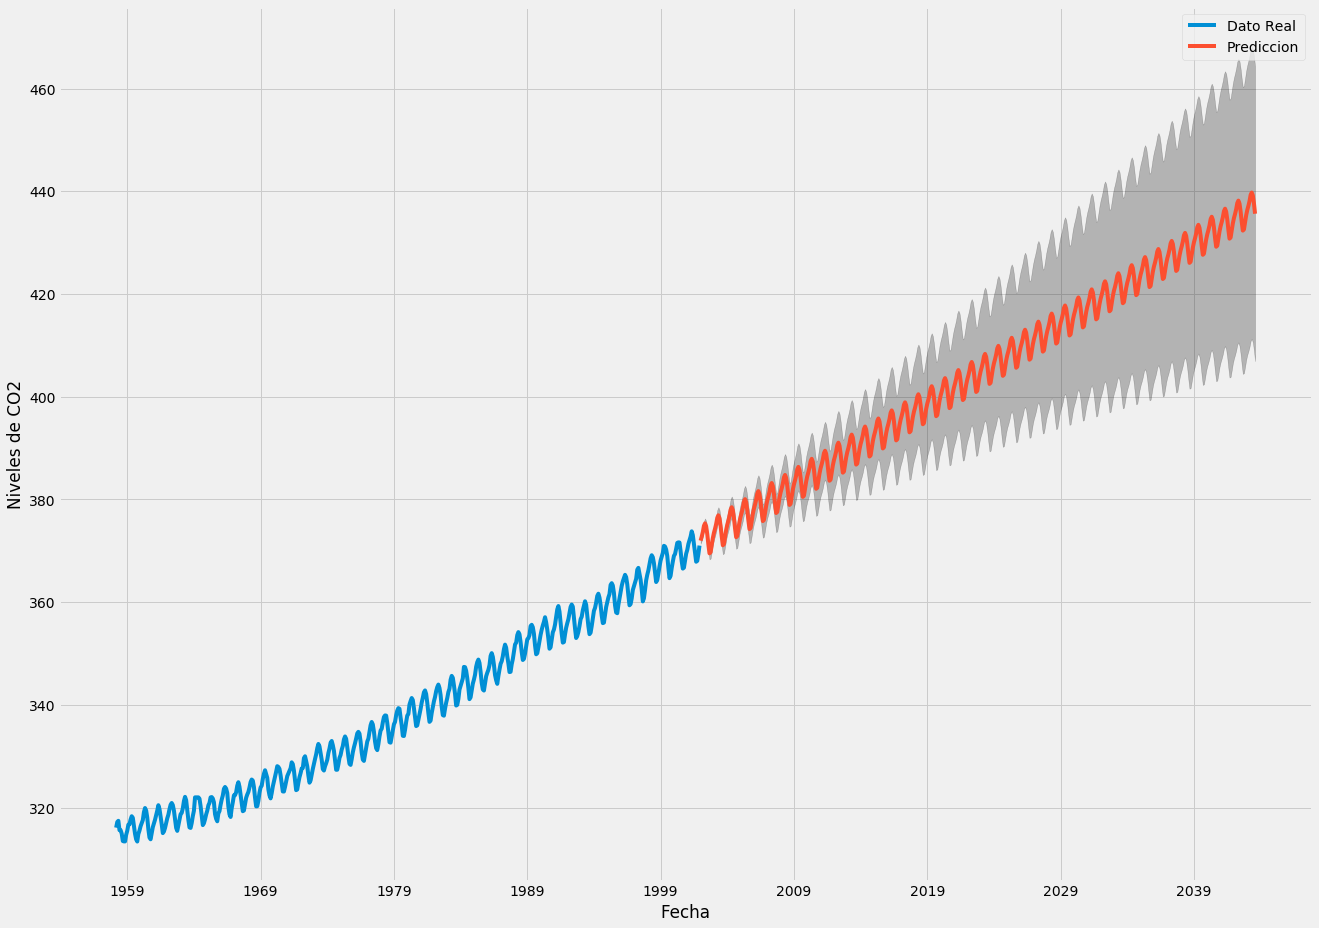

In [53]:
ax = y.plot(label='Dato Real', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Prediccion')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('Niveles de CO2')

plt.legend()
plt.show()

A medida que nos proyectamos hacia el futuro, es natural que confiemos menos en los valores estimados. Esto se refleja en el aumento de los intervalos de confianza a medida que avanzamos hacia el futuro.

## Notas

Algunas otras cosas que se pueden probar:

- Modificar la fecha de inicio de las predicciones dinámicas para ver cómo afecta esto a la calidad.
- Probar más combinaciones de parámetros para ver si puede mejorar la calidad del modelo.
- Seleccionar una métrica diferente para seleccionar el mejor modelo. Por ejemplo, hemos usado la ```AIC``` para encontrar el mejor modelo, pero podría buscar optimizar el MSE.